In [1]:
import pickle
import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import random

import torch
from torch import optim
from torch.nn import functional as F

import os
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from seaborn import heatmap, lineplot, clustermap
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from etm import ETM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current backend is: ", device)
random.seed(10)

Current backend is:  cpu


In [2]:
# mouse pancreas single-cell dataset
# read in data and cell type labels
with open('data/MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open('data/MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)
    
df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open('data/cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv('data/sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

In [3]:
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari

In [4]:
model = ETM(num_topics=K,
            vocab_size=len(genes),
            t_hidden_size=256,
            rho_size=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            enc_drop=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)

In [5]:
# train the VAE for one epoch
def train_scETM_helper(model, X_tensor, X_tensor_normalized):
    # initialize the model and loss
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    return torch.sum(loss).item()


# get sample encoding theta from the trained encoder network
def get_theta(model, input_x):
    model.eval()
    with torch.no_grad():
        q_theta = model.q_theta(input_x)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta

# Q1 Train ETM on mouse pancreas scRNA-seq data

In [6]:
def train_scETM(model, X_tensor, X_tensor_normalized, adata=mp_anndata, niter=1000):
    """
        :param model: the scETM model object
        :param X_tensor: NxM raw read count matrix X
        :param X_tensor_normalized: NxM normalized read count matrix X
        :param adata: annotated single-cell data object with ground-truth cell type information for evaluation
        :param niter: maximum number of epochs
        :return:
            1. model: trained scETM model object
            2. perf: niter-by-3 ndarray with iteration index, NELBO, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')
    
    # WRITE YOUR CODE HERE
    
    for iter in range(niter) :
        loss = train_scETM_helper(model, X_tensor, X_tensor_normalized)
        with torch.no_grad():
            theta = get_theta(model, X_tensor_normalized)
            ari = evaluate_ari(theta, adata)
            
        perf[iter, 0] = iter
        perf[iter, 1] = loss
        perf[iter, 2] = ari

        if iter % 10 == 0:  # print out performance every 10 iterations
            print(f'Iter: {iter}, Loss: {loss:.4f}, ARI: {ari:.4f}')

    return model, perf

def monitor_perf(perf, objective, path=""):
    """
    :param perf: niter-by-3 ndarray with iteration index, objective function, and ARI as the 3 columns
    :param objective: 'NELBO'
    :param path: path to save the figure if not display to the screen
    :behaviour: display or save a 2-by-1 plot showing the progress of optimizing objective and ARI as
        a function of iterations
    """
    # WRITE YOUR CODE HERE
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot Negative ELBO
    axes[0].plot(perf[:, 0], perf[:, 1], label='Negative ELBO')
    axes[0].set_title('Training Negative ELBO')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel(objective)
    axes[0].legend()

    # Plot ARI
    axes[1].plot(perf[:, 0], perf[:, 2], label='ARI', color='orange')
    axes[1].set_title('ARI Across Iterations')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('ARI')
    axes[1].legend()

    plt.tight_layout()

    if path:
        plt.savefig(path)
    else:
        plt.show()

In [7]:
model, scetm_perf = train_scETM(model, X_tensor, X_tensor_normalized, niter=1000)

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iter: 0, Loss: 9688.4160, ARI: 0.5626
Iter: 10, Loss: 9368.7861, ARI: 0.5911
Iter: 20, Loss: 9043.9482, ARI: 0.4100
Iter: 30, Loss: 8727.2744, ARI: 0.3472
Iter: 40, Loss: 8511.9961, ARI: 0.5593
Iter: 50, Loss: 8306.2676, ARI: 0.6940
Iter: 60, Loss: 8133.5063, ARI: 0.5087
Iter: 70, Loss: 7963.9814, ARI: 0.4496
Iter: 80, Loss: 7864.2251, ARI: 0.3494
Iter: 90, Loss: 7797.2549, ARI: 0.5394
Iter: 100, Loss: 7753.1440, ARI: 0.3872
Iter: 110, Loss: 7718.3721, ARI: 0.3833
Iter: 120, Loss: 7690.3364, ARI: 0.4419
Iter: 130, Loss: 7660.5737, ARI: 0.4653
Iter: 140, Loss: 7631.1069, ARI: 0.3930
Iter: 150, Loss: 7600.0498, ARI: 0.4738
Iter: 160, Loss: 7568.5073, ARI: 0.3921
Iter: 170, Loss: 7539.9741, ARI: 0.3905
Iter: 180, Loss: 7513.7285, ARI: 0.3893
Iter: 190, Loss: 7496.0234, ARI: 0.4759
Iter: 200, Loss: 7480.3281, ARI: 0.4877
Iter: 210, Loss: 7469.0786, ARI: 0.5478
Iter: 220, Loss: 7458.7710, ARI: 0.6968
Iter: 230, Loss: 7449.3228, ARI: 0.6986
Iter: 240, Loss: 7443.3452, ARI: 0.5250
Iter: 250, 

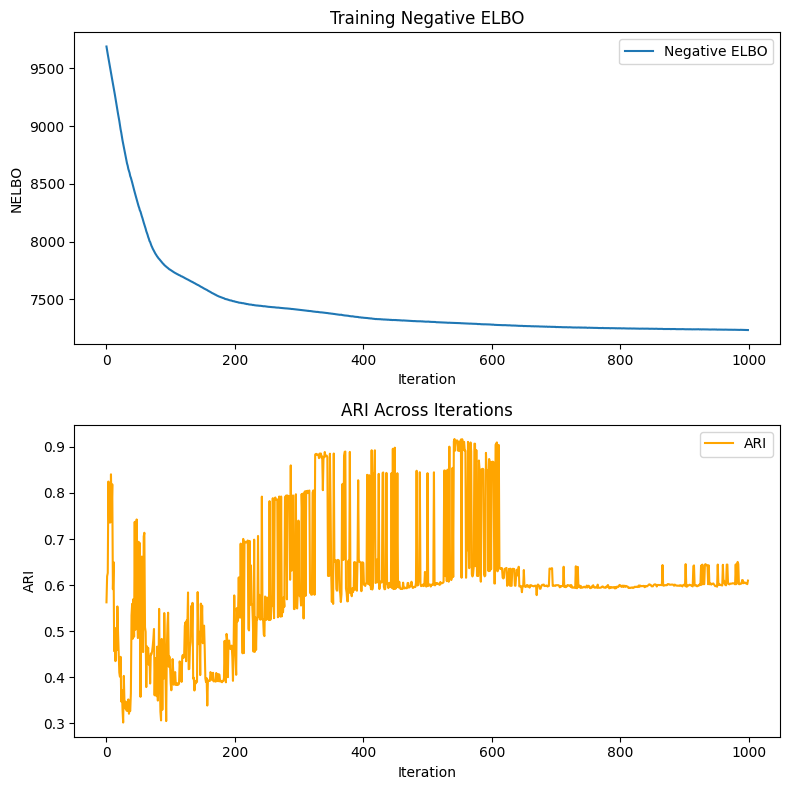

In [8]:
monitor_perf(scetm_perf, "NELBO")

# Q2 Plot t-SNE or UMAP

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


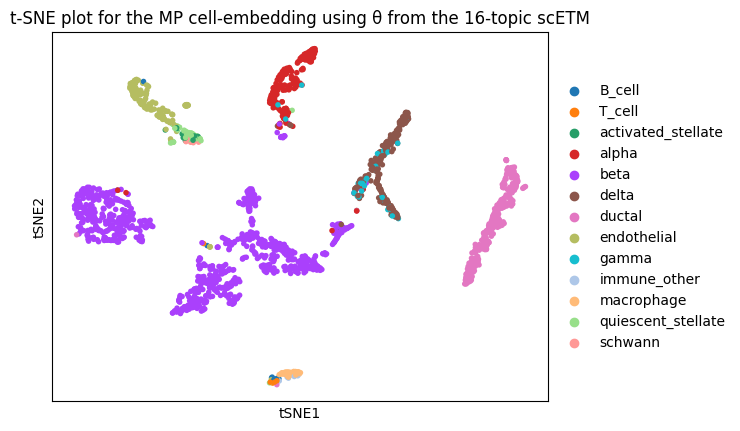

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


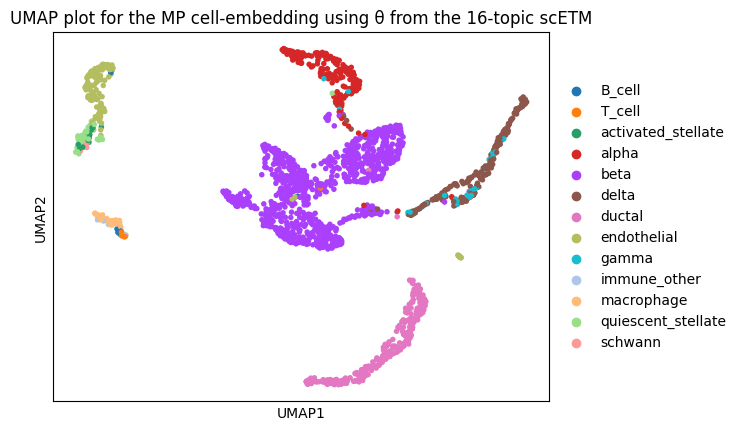

In [9]:
# WRITE YOUR CODE HERE

# Extracting the final cell topic embedding θ for the visualization
with torch.no_grad():
    cell_embeddings = get_theta(model, X_tensor_normalized).cpu().numpy()

# Adding the cell embeddings to the AnnData object
mp_anndata.obsm['X_scETM'] = cell_embeddings

# Running t-SNE
sc.tl.tsne(mp_anndata, use_rep='X_scETM')

# Running UMAP
sc.pp.neighbors(mp_anndata, use_rep='X_scETM', n_neighbors=30)
sc.tl.umap(mp_anndata)

# Plotting the t-SNE results
sc.pl.tsne(mp_anndata, color='Celltype', title='t-SNE plot for the MP cell-embedding using θ from the 16-topic scETM')

# Plotting the UMAP results
sc.pl.umap(mp_anndata, color='Celltype', title='UMAP plot for the MP cell-embedding using θ from the 16-topic scETM')


# Q3 plot cells by topics

In [10]:
# WRITE YOUR CODE HERE

# Q4 Plot genes-by-topics

In [11]:
# WRITE YOUR CODE HERE